Instructions:

https://docs.google.com/document/d/1EUrcRXN7OWYpOvrb8mcUJYZn1vdR63MoLpuFz8ep10I/edit?usp=sharing

תרגיל - ניתוח טקסט - סיווג  סנטימנט

מטרת התרגיל היא לסווג סנטימנט שלילי/חיובי מתוך תגובות בדף הפייסבוק של הנשיא ריבלין.
ראשית, יש להיכנס לקישור הבא:
https://github.com/omilab/Neural-Sentiment-Analyzer-for-Modern-Hebrew
בקישור הנ״ל אפשר למצוא שני jupyter notebooks שבשלב זה לא רלוונטיים, אפשר להתעלם מהן. מה שכן נדרש שקריאת ההסבר בקובץ readme וקריאת המאמר עצמו. 
לאחר השלמת החלק התיאורטי, נדרש לכתוב מסווג פשוט המבוסס על TF-IDF אך לא רק ואפשר להשתמש ברעיונות נוספים כמו למשל POS. הרעיון, לממש מסווג פשוט ולא רשתות עמוקות, למשל אפשר להשתמש ב-Logistic Regression Classifier.


References
Introduction to Information Retrieval
Tf-idf weighting
How to Use Tfidftransformer & Tfidfvectorizer - A Short Tutorial
sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.24.2 documentation


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from nltk.tokenize import TreebankWordTokenizer

from keras.utils.np_utils import to_categorical
import emoji
import re
import string
import json
import codecs
import pandas as pd
import os
from nltk.corpus import stopwords
import string
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import operator
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import time
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering

# Loading the data

In [2]:
def load_data(filename):
    data = list(codecs.open(filename, 'r', 'utf-8').readlines())
    x, y = zip(*[d.strip().split('\t') for d in data])
    # Reducing any char-acter sequence of more than 3 consecutive repetitions to a respective 3-character sequence 
    # (e.g. “!!!!!!!!”turns to “!!!”)
    # x = [re.sub(r'((.)\2{3,})', r'\2\2\2', i) for i in x]
    x = np.asarray(list(x))
    y = np.array(y).astype(np.int)
    #y = to_categorical(y, 3)
    
    
    return x, y

In [3]:
x_token_train, y_token_train = load_data('data/token_train.tsv')
x_token_test, y_token_test = load_data('data/token_test.tsv')
x_morph_train, y_morph_train = load_data('data/morph_train.tsv')
x_morph_test, y_morph_test = load_data('data/morph_test.tsv')


In [4]:
stopwords_he = pd.read_excel('stopwords-he.xlsx')

In [5]:
stopwords_he_list = stopwords_he.Undotted

In [6]:
# putting in dataframe

train_df = pd.DataFrame()
train_df["x_token_train"] = x_token_train
train_df["y_token_train"] = y_token_train
train_df["x_morph_train"] = x_morph_train
train_df["y_morph_train"] = y_morph_train

test_df = pd.DataFrame()
test_df["x_token_test"] = x_token_test
test_df["y_token_test"] = y_token_test
test_df["x_morph_test"] = x_morph_test
test_df["y_morph_test"] = y_morph_test


# EDA

## train_df

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   x_token_train  10244 non-null  object
 1   y_token_train  10244 non-null  int32 
 2   x_morph_train  10244 non-null  object
 3   y_morph_train  10244 non-null  int32 
dtypes: int32(2), object(2)
memory usage: 240.2+ KB


In [8]:
train_df.describe()

,y_token_train,y_morph_train
count,10244.00000,10244.00000
mean,0.36392,0.36392
std,0.53823,0.53823
min,0.00000,0.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,1.00000,1.00000
max,2.00000,2.00000


<AxesSubplot:ylabel='y_token_train'>

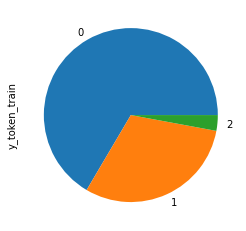

In [9]:
train_df.y_token_train.value_counts().plot(kind ='pie')

In [10]:
train_df.corr()

,y_token_train,y_morph_train
y_token_train,1.0,1.0
y_morph_train,1.0,1.0


In [11]:
train_df[train_df.y_token_train == 0][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,0
1,איש יקר שלנו,0,איש יקר של אנחנו,0
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה,0
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,0


In [12]:
train_df[train_df.y_token_train == 1][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
9,אדוני הנשיא סליחה על הבוטות תפסיק לזיין את השכ...,1,אדוני ה נשיא סליחה על ה בוטות תפסיק לזיין את ה...,1
11,ואני עוד חשבתי שהגיע נשיא נורמלי,1,ו אני עוד חשבתי ש הגיע נשיא נורמלי,1
12,נשיא המדינה הלבן והמנותק חכם בדיבורים . הוא לא...,1,נשיא ה מדינה ה לבן ו ה מנותק חכם ב ה דיבורים ....,1
14,""" רובי ריבלין היקר !! אתה איש משפחה לא ???.. מ...",1,""" רובי ריבלין ה יקר !! אתה איש משפחה לא ???.. ...",1
18,עוד לא שבוע בתפקיד וכבר שכחת מאיפה באת ?,1,עוד לא שבוע ב ה תפקיד ו כבר שכחת מ איפה באת ?,1


In [13]:
train_df[train_df.y_token_train == 2][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
53,חייבים לעשות סוג של חרם כשכתבים שונאי ישראל עו...,2,חייבים לעשות סוג של חרם כש כתבים שונאי ישראל ע...,2
78,אז אתה בא ? https://www.facebook.com/events/15...,2,אז אתה בא ? https://www.facebook.com/events/15...,2
82,""" גאי אתה טיפש מטופש ילד כאפות שלא חונך על ברכ...",2,""" גאי אתה טיפש מטופש ילד כאפות ש לא חונך על בר...",2
117,שמעון יפרח העלאתי בשבילך את דבריו של שמעון פרס...,2,ש מעון יפרח העלאתי בשביל אתה את דבריו של שמעון...,2
181,רובי ריבלין הנשיא העשירי תחזית שניתנה לפני הבח...,2,רובי ריבלין ה נשיא ה עשירי תחזית ש ניתנה לפני ...,2


The dataset contains:
1. **x_token_train** - collection of talkback as strings
2. **y_token_train** - Sentiment classification (target), (0 - Positive, 1 - Negative, 2 - Neutral)
3. **x_morph_train** - same as x_token_train, but seperated to prefix, nuclear word, suffix (morphologically rich language)
4. **y_morph_train** - same as y_token_train, since it is the same sentiment

morph examples:    

    לנשיאות
    ל ה נשיאות

    לה הצלחה
    ל היא הצלחה

In [14]:
# dropping the duplicate y_morph_train column

In [15]:
train_df.drop('y_morph_train', axis='columns', inplace=True)
train_df.rename(columns={"y_token_train": "y_train"}, inplace=True)

In [16]:
train_df.head()

,x_token_train,y_train,x_morph_train
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...
1,איש יקר שלנו,0,איש יקר של אנחנו
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ..."
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .


In [17]:
# Cleaning methods:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def keep_only_heb(p_text):
    CHARS_PATTERN = re.compile(r"""[^אבגדהוזחטיכלמנסעפצקרשתןףץםך'\- "]""")
    return CHARS_PATTERN.sub('', p_text)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    text = [word for word in text.split() if word not in stop_words]
    return " ".join(text)

def remove_k_length(text, k = 1):
    text = [word for word in text.split() if len(word) > 1]
    return " ".join(text)

def consildate_k_chars(text, k):
    while True:
        count = 0
        chars = set(text)
        for c in chars:
            if c * k in text:
                text = text.replace(c * k, c)
                count += 1
        if count == 0:
            break
    return text

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [18]:
# adding a clean token column
stop_words =[]
with open('hebrew_stop_words.json', 'r', encoding="utf8") as f:
    stop_words = json.load(f)
    
# use get_display to convert the hebrew stop words, so the word cloud won't be reversed 
bd_hsw = get_display(" ".join(stop_words)).split(" ")

train_df["clean_morph"] = train_df.x_morph_train.map(lambda x: keep_only_heb(x))
train_df["clean_morph"] = train_df.clean_morph.map(lambda x: remove_URL(x))
train_df["clean_morph"] = train_df.clean_morph.map(lambda x: remove_html(x))
train_df["clean_morph"] = train_df.clean_morph.map(lambda x: remove_emoji(x))
train_df["clean_morph"] = train_df.clean_morph.map(lambda x: remove_punct(x))
train_df["clean_morph"] = train_df.clean_morph.map(lambda x: remove_stopwords(x))
train_df["clean_morph"] = train_df.clean_morph.map(lambda x: remove_k_length(x))
train_df["clean_len"] = train_df.clean_morph.map(lambda x: len((x)))
train_df = train_df[train_df.clean_len > 10]
train_df.describe()
train_df.head()


,x_token_train,y_train,x_morph_train,clean_morph,clean_len
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,ממש כואב בכה משפחה תדעו עוד צער,31
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה,כבוד המון הצלחה,15
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",תל חי רובי עצב היית קרן אור תקוה אכן נשיא ישראל,47
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,נקי כפיים בר לבב הצלחה,22
5,רובי חג שמח והצלחה בבחירות לנשיאות .,0,רובי חג שמח ו הצלחה ב בחירות ל ה נשיאות .,רובי חג שמח הצלחה בחירות נשיאות,31


In [19]:
test_df.head()

,x_token_test,y_token_test,x_morph_test,y_morph_test
0,""" שמע ישראל , השם ישמור ויקרא הגורל = ( י.ק.ו....",0,""" שמע ישראל , ה שם ישמור ו יקרא ה גורל = ( י....",0
1,איחולי הצלחה בתפקידך .,0,איחולי הצלחה ב תפקידך .,0
2,כל הכבוד !!!,0,כל ה כבוד !!!,0
3,""" בוקר טוב ישראל בוקר טוב לכבוד נשיא מדינת ישר...",0,""" בוקר טוב ישראל בוקר טוב לכבוד נשיא מדינת ישר...",0
4,איפה הגינוי ? http://www.iba.org.il/bet/bet.as...,1,איפה ה גינוי ? http://www.iba.org.il/bet/bet.a...,1


In [20]:
test_df["clean_morph"] = test_df.x_morph_test.map(lambda x: keep_only_heb(x))
test_df["clean_morph"] = test_df.clean_morph.map(lambda x: remove_URL(x))
test_df["clean_morph"] = test_df.clean_morph.map(lambda x: remove_html(x))
test_df["clean_morph"] = test_df.clean_morph.map(lambda x: remove_emoji(x))
test_df["clean_morph"] = test_df.clean_morph.map(lambda x: remove_punct(x))
test_df["clean_morph"] = test_df.clean_morph.map(lambda x: remove_stopwords(x))
test_df["clean_morph"] = test_df.clean_morph.map(lambda x: remove_k_length(x))
test_df["clean_len"] = test_df.clean_morph.map(lambda x: len((x)))
test_df = test_df[test_df.clean_len > 10]
test_df.describe()
test_df.head()

,x_token_test,y_token_test,x_morph_test,y_morph_test,clean_morph,clean_len
0,""" שמע ישראל , השם ישמור ויקרא הגורל = ( י.ק.ו....",0,""" שמע ישראל , ה שם ישמור ו יקרא ה גורל = ( י....",0,שמע ישראל ישמור יקרא גורל יקוק אימרו אמן אבא ב...,223
1,איחולי הצלחה בתפקידך .,0,איחולי הצלחה ב תפקידך .,0,איחולי הצלחה תפקידך,19
3,""" בוקר טוב ישראל בוקר טוב לכבוד נשיא מדינת ישר...",0,""" בוקר טוב ישראל בוקר טוב לכבוד נשיא מדינת ישר...",0,בוקר טוב ישראל בוקר טוב לכבוד נשיא מדינת ישראל...,127
5,""" מילים רגישות ונכונות כתמיד מפיך , חסר רק אזכ...",0,""" מילים רגישות ו נכונות כ תמיד מ פיך , חסר רק ...",0,מילים רגישות נכונות תמיד פיך חסר אזכור ספורט נ...,186
6,נכון שמאחרת לברך ונכון שאני הקטנה מכולם אבל לא...,0,נכון ש מאחרת לברך ו נכון ש אני ה קטנה מ כולם א...,0,נכון מאחרת לברך נכון קטנה אחרונה לברך האמין הצ...,72


# Error Analysis

##  1. Find high distinctive words

as in the reference example, we will use <code>ExtraTreesClassifier</code> and <code>CountVectorizer(word)</code> in order to find out which of the words.

We will use the text that have gone
1. Morphing (ובהצלחה -> ו ב הצלחה)
2. Extracting only hebrew words
3. Removing more than 3 duplicate charecters (שולטטטטט-> שולט)

### 1.a Plot word frequency, wordclouds, connection words that affect the classification

In [21]:
clean_train_df = train_df.copy()
clean_train_df = clean_train_df[['clean_morph', 'y_train']]

clean_test_df = test_df.copy()
clean_test_df = clean_test_df[['clean_morph', 'y_morph_test']]

#### wordcloud

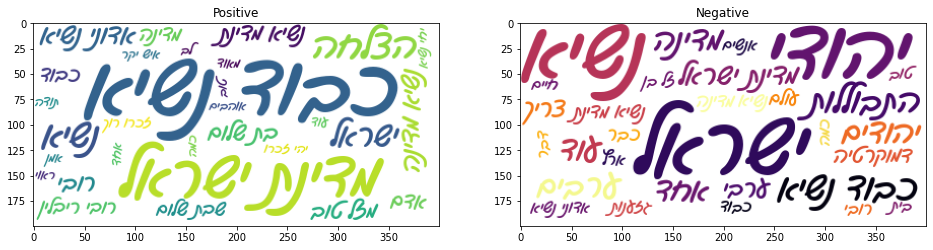

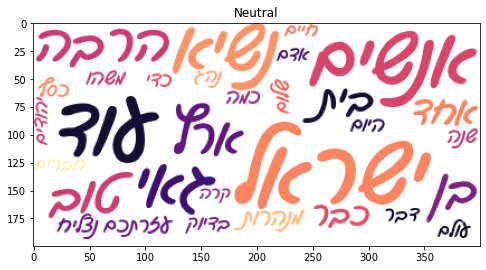

In [22]:
# Display 

# (as in the previous exerceise, but now with a cleaner text)

from wordcloud import WordCloud
all_positive_wc = WordCloud(
    colormap='viridis',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(clean_train_df[clean_train_df.y_train==0].clean_morph)))

all_negative_wc = WordCloud(
    colormap='inferno',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(clean_train_df[clean_train_df.y_train==1].clean_morph)))

all_neutral_wc = WordCloud(
    colormap='magma',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(clean_train_df[clean_train_df.y_train==2].clean_morph)))

plt.figure(1, figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title("Positive")
plt.imshow(all_positive_wc)

plt.subplot(1, 2, 2)
plt.title("Negative")
plt.imshow(all_negative_wc)

plt.figure(2, figsize=(8, 8))
plt.title("Neutral")
plt.imshow(all_neutral_wc)

#### word frequency

Positive sentiment

In [23]:
vect = CountVectorizer(analyzer='word', lowercase=False)
vect_pos = vect.fit_transform(clean_train_df[clean_train_df.y_train == 0].clean_morph)

# Visualising the high frequency words for positive set

df_pos_freq = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['pos_frequency']).T
most_freq_pos = df_pos_freq.nlargest(6, 'pos_frequency')

In [24]:
most_freq_pos

,pos_frequency
נשיא,3052
כבוד,1403
הצלחה,1255
ישראל,1035
רובי,706
שלום,618


Negative Sentiment

In [25]:
vect = CountVectorizer(analyzer='word', lowercase=False)
vect_neg = vect.fit_transform(clean_train_df[clean_train_df.y_train == 1].clean_morph)

# Visualising the high frequency words for positive set

df_neg_freq = pd.DataFrame(vect_neg.sum(axis=0), columns=list(vect.get_feature_names()), index = ['neg_frequency']).T
most_freq_neg = df_neg_freq.nlargest(6, 'neg_frequency')

In [26]:
most_freq_neg

,neg_frequency
נשיא,1604
ישראל,1005
מדינה,610
יהודי,551
כבוד,550
התבוללות,523


Neutral Sentiment

In [27]:
vect = CountVectorizer(analyzer='word', lowercase=False)
vect_nut = vect.fit_transform(clean_train_df[clean_train_df.y_train == 2].clean_morph)

# Visualising the high frequency words for positive set

df_nut_freq = pd.DataFrame(vect_nut.sum(axis=0), columns=list(vect.get_feature_names()), index = ['nut_frequency']).T
nut_freq_neg = df_nut_freq.nlargest(6, 'nut_frequency')

In [28]:
nut_freq_neg

,nut_frequency
ישראל,48
אנשים,32
נשיא,31
עוד,31
גאי,25
צפון,24


Displaying most frequent pos/neg words:

In [29]:
merged_index = most_freq_neg.index.append(most_freq_pos.index).append(nut_freq_neg.index)

In [30]:
merged_index

Index(['נשיא', 'ישראל', 'מדינה', 'יהודי', 'כבוד', 'התבוללות', 'נשיא', 'כבוד',
       'הצלחה', 'ישראל', 'רובי', 'שלום', 'ישראל', 'אנשים', 'נשיא', 'עוד',
       'גאי', 'צפון'],
      dtype='object')

In [31]:
word_freq_df = pd.DataFrame()

for feature in set(merged_index):
    pos_freq = neg_freq = nut_freq = 0
    if feature in df_pos_freq.index:
        pos_freq = df_pos_freq.loc[feature].pos_frequency
        
    if feature in df_neg_freq.index:
        neg_freq = df_neg_freq.loc[feature].neg_frequency
        
    if feature in df_nut_freq.index:
        nut_freq = df_nut_freq.loc[feature].nut_frequency
    
    word_freq_df = word_freq_df.append(
        {'feature'  : get_display(feature),
         'orig_feature' : feature,
         'pos_freq' : pos_freq,
         'neg_freq' : neg_freq,
         'nut_freq' : nut_freq},
        ignore_index=True)
    
word_freq_df.set_index('feature', inplace=True)

In [32]:
word_freq_df

,neg_freq,nut_freq,orig_feature,pos_freq
feature,,,,
הנידמ,610.0,10.0,מדינה,580.0
החלצה,33.0,6.0,הצלחה,1255.0
ןופצ,5.0,24.0,צפון,6.0
תוללובתה,523.0,2.0,התבוללות,49.0
דובכ,550.0,17.0,כבוד,1403.0
אישנ,1604.0,31.0,נשיא,3052.0
יבור,301.0,9.0,רובי,706.0
םולש,132.0,16.0,שלום,618.0
םישנא,160.0,32.0,אנשים,125.0


<AxesSubplot:ylabel='feature'>

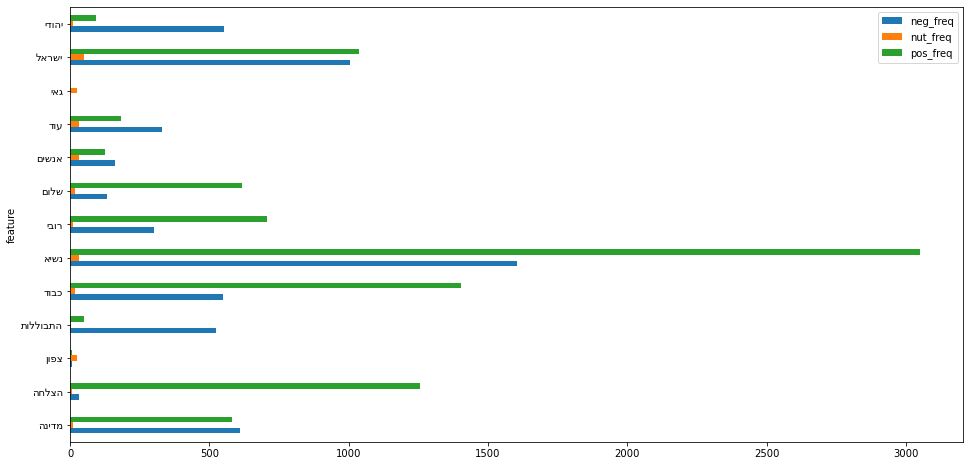

In [33]:
word_freq_df.plot(kind = 'barh', figsize=(16,8))

## 2. Perform a naive classification based on the words found

Check dataset balance

In [34]:
clean_train_df.y_train.value_counts(normalize=True)

0    0.637297
1    0.333113
2    0.029590
Name: y_train, dtype: float64

<AxesSubplot:ylabel='y_train'>

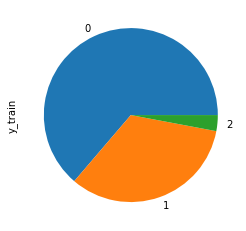

In [35]:
clean_train_df.y_train.value_counts().plot(kind ='pie')

There is a positive bias in dataset, so the positive classification is biased

In [36]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

In [37]:
def show_most_informative_features(vectorizer, clf, n=20):
    # https://inblog.in/Feature-Importance-in-Naive-Bayes-Classifiers-5qob5d5sFW
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    important_feature = coefs_with_fns[:-(n + 1):-1]
    
    print("important_features: ")
    for feature in important_feature:
        print(feature)

In [1]:
# classify the dataset using ExtraTreesClassifier and CountVectorizer (as in the refernce)
def perform_classification(train_words, train_target, test_words):
    
    ################################## Splitting with feature selection data ###############################a

    # Vectorising the required data
    vect_algo = TfidfVectorizer(lowercase=False, ngram_range=(1, 1), analyzer='word')
    vect_algo.fit(train_words)
    Xf_train = vect_algo.transform(train_words)
    Xf_test = vect_algo.transform(test_words)

    # Encoding target data
    # Creating an object and fitting on target strings
    le = LabelEncoder()
    yf_train = le.fit_transform(train_target)
    
    ########################################### Naive Bayes #########################################

    # Fit the Naive Bayes classifier model to the object
    clf = MultinomialNB()
    clf.fit(Xf_train, yf_train)

    # predict the outcome for testing data
    predictions = clf.predict(Xf_test)
    
    show_most_informative_features(vect_algo, clf )

    return predictions

In [39]:
y_predict = perform_classification(
    clean_train_df.clean_morph,
    clean_train_df.y_train,
    clean_test_df.clean_morph)


important_features: 
(-4.4910829730212365, 'נשיא')
(-4.750195746439047, 'הצלחה')
(-4.827365395427418, 'כבוד')
(-5.333458789073194, 'שלום')
(-5.368122943203613, 'ישראל')
(-5.424658629110523, 'רובי')
(-5.607098348841417, 'טוב')
(-5.692956424075565, 'מדינת')
(-5.704987849634659, 'יקר')
(-5.710523011567993, 'בת')
(-5.785036792327588, 'איש')
(-5.795307148995947, 'אדוני')
(-5.826337433609571, 'ריבלין')
(-5.869042217447564, 'מדינה')
(-5.894985274452706, 'רוך')
(-5.915873017654391, 'יהי')
(-5.922611583432285, 'אוהבים')
(-5.932364270411059, 'מזל')
(-5.99790845657988, 'זכרו')
(-6.020482184647493, 'לב')


C:\Users\eyalshw\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


The feature importance is similar to the naive frequency count

## 3. Explain the confusion matrix

In [40]:
le = LabelEncoder()
y_true = le.fit_transform(clean_test_df.y_morph_test)

In [41]:
cf_matrix = confusion_matrix(y_true, y_predict)
print(cf_matrix)

[[1377   48    0]
 [ 179  582    0]
 [  36   31    2]]


<AxesSubplot:>

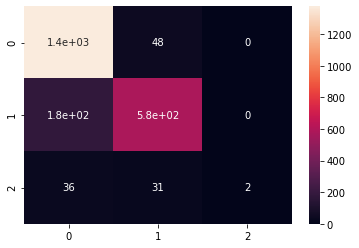

In [42]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [43]:
cf_matrix

array([[1377,   48,    0],
       [ 179,  582,    0],
       [  36,   31,    2]], dtype=int64)

In [44]:
target_names = ['Positive', 'Negative', 'Neutral']
print(classification_report(y_true, y_predict, target_names=target_names, digits=4))

              precision    recall  f1-score   support

    Positive     0.8649    0.9663    0.9128      1425
    Negative     0.8805    0.7648    0.8186       761
     Neutral     1.0000    0.0290    0.0563        69

    accuracy                         0.8696      2255
   macro avg     0.9151    0.5867    0.5959      2255
weighted avg     0.8743    0.8696    0.8548      2255



Model Estimation

1. From the confusion matrix we can see the there are a lot of negative sentiment were wrongly classified as positive
2. There is a bias in the model for positive sentiments 
3. There is very small amount of neutral sentiments, which leads to the big difference between the high precision, low recall and low f1-score
4. Overall accuarcy is 86.96%
